In [1]:
# run these in the command line before executing this notebook
# ! pip install fastai; 
# ! pip install ipykernel torch torchaudio torchvision

# NOTE: Start with this article to understand!!
# https://walkwithfastai.com/Binary_Segmentation

In [2]:
from fastai import *
from fastai.vision.all import *
from IPython.display import clear_output, DisplayHandle

torch.cuda.is_available()

def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [3]:
project_directory = Path.cwd().joinpath('../')
path = project_directory.joinpath('data/mitochondria_data/training')
print(path)

image_paths = path / "images"
mask_paths = path / "masks"


/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training


In [4]:
image_files = image_paths.ls()
mask_files = mask_paths.ls()


input_image_size = Image.open(image_files[0]).size
print(f'Size of an image: {input_image_size}')
square_size = input_image_size[0]

print(image_files)
print(mask_files)
print(np.unique(Image.open(image_files[0])))
print(np.unique(Image.open(mask_files[0])))


Size of an image: (256, 256)
[Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_100_0_1.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_45_1_0.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_128_0_1.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_47_0_1.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_39_0_0.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_17_2_0.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_41_0_1.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/trainin

In [5]:
print(mask_files[0].name)
print(image_files[0].name)
print(image_files)

training_groundtruth_0_2_1.tif
training_100_0_1.tif
[Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_100_0_1.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_45_1_0.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_128_0_1.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_47_0_1.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_39_0_0.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_17_2_0.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_41_0_1.tif'), Path('/home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mi

In [6]:
# Define a function to get the mask file path from an image file path
import matplotlib.pyplot as plt
# Now, our mask isn't set up how fastai expects, in which the mask points are not all in a row. We need to change this:
# # We'll do this through an n_codes function. What this will do is run through our masks and build a set based on the unique values 
# present in our masks. 
# From there we will build a dictionary that will replace our points once we load in the image
def n_codes(fnames, is_partial=True):
  "Gather the codes from a list of `fnames`, full file paths"
  vals = set()
  if is_partial:
    random.shuffle(fnames)
    fnames = fnames[:10]
  for fname in fnames:
    msk = np.array(PILMask.create(fname))
    for val in np.unique(msk):
      if val not in vals:
        vals.add(val)
  vals = list(vals)
  p2c = dict()
  for i,val in enumerate(vals):
    p2c[i] = vals[i]
  return p2c

p2c = n_codes(mask_files)

print(p2c)


{0: 0, 1: 255}


Text(0.5, 1.0, 'Mask')

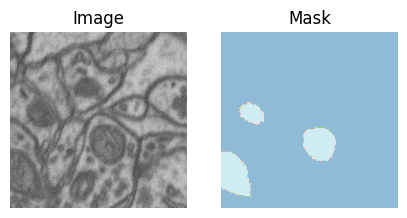

In [7]:
def get_mask_file(image_file, p2c, base_name='training_groundtruth', mask_paths=mask_paths):
    nums = re.findall(string=image_file.name, pattern=r"\d+_\d+_\d+")[0]  # remove from list
    str_name = f'{base_name}_'+nums + image_file.suffix
    mask_path = (mask_paths/str_name)
    msk = np.array(PILMask.create(mask_path))
    mx = np.max(msk)
    for i, val in enumerate(p2c):
        # print(i, val)
        msk[msk==p2c[i]] = val
    return PILMask.create(msk)


def get_y(o): 
    return get_mask_file(o, p2c)

fig, ax = plt.subplots(1, 2, figsize=(5, 5))
im = PILImage.create(image_files[0])
im.show(ax[0])
ax[0].set_title("Image")

msk = get_y(image_files[0])
msk.show(ax[1])
ax[1].set_title("Mask")

Unique values in the mask: [0 1]
Unique values in the mask: [0]
Unique values in the mask: [0 1]
Unique values in the mask: [0 1]
Unique values in the mask: [0 1]


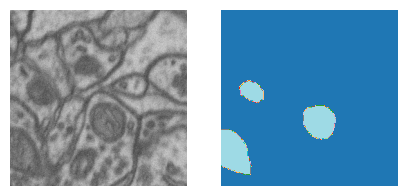

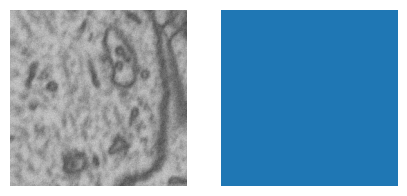

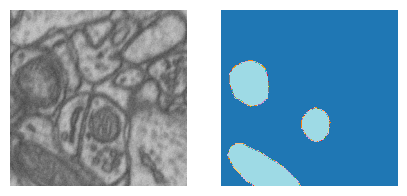

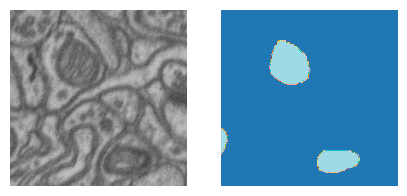

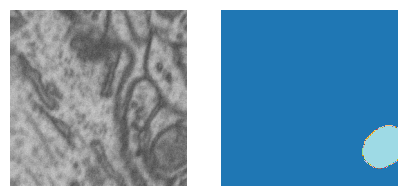

In [8]:
def show_mask(img_fn):
    img = PILImage.create(img_fn)
    msk = PILMask.create(get_mask_file(img_fn, p2c))

    fig, ax = plt.subplots(1, 2, figsize=(5, 5))

    # Show image on left axis
    img.show(ax=ax[0])

    # Show mask on right axis
    msk.show(ax=ax[1], alpha=1)

    print(f"Unique values in the mask: {np.unique(np.array(msk))}")


# Show a few masks and their unique values
for image_path in image_files[:5]:
    show_mask(image_path)


In [9]:
# set up the datablock 
mitos = DataBlock(blocks=(ImageBlock, MaskBlock(codes=np.array(['not_mito', 'mito']))),
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  get_items=get_image_files,
                  get_y=get_y, #get_mask_file,  # Use the custom getter function for masks
                  item_tfms=[RandomResizedCrop(512, min_scale=0.3)],  # this is super important - upscale the crop at each batch randomly
                  batch_tfms=[*aug_transforms(size=224)],  # this is so important apparently
                  n_inp=1,
                  )

dls = mitos.dataloaders(image_paths, bs=16)
mitos.summary(image_paths, bs = 16)

Setting-up type transforms pipelines
Found 1980 items
2 datasets of sizes 1584,396
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_11_1_2.tif
    applying PILBase.create gives
      PILImage mode=RGB size=256x256
  Pipeline: get_y -> PILBase.create
    starting from
      /home/ncamarda/coding/endotheliosisQuantifier/scripts/../data/mitochondria_data/training/images/training_11_1_2.tif
    applying get_y gives
      PILMask mode=L size=256x256
    applying PILBase.create gives
      PILMask mode=L size=256x256

Final sample: (PILImage mode=RGB size=256x256, PILMask mode=L size=256x256)


Found 1980 items
2 datasets of sizes 1584,396
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> RandomResizedCrop -

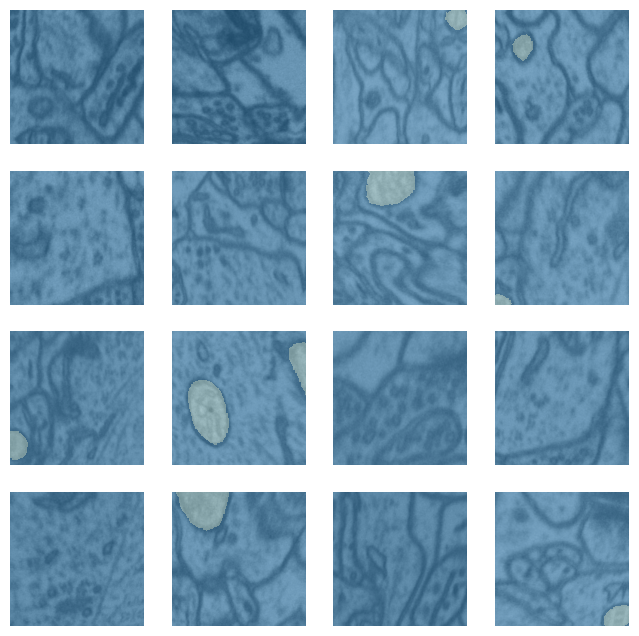

In [10]:
batch_size = 16
dls.show_batch(max_n=batch_size, vmin=0, vmax=1, figsize=(batch_size/2,batch_size/2))

In [11]:
x, y = dls.one_batch()
print("Input shape:", x.shape)
print("Target shape:", y.shape)


Input shape: torch.Size([16, 3, 224, 224])
Target shape: torch.Size([16, 224, 224])


In [12]:
# these are different kinds of loss functions!

# from torch.nn import CrossEntropyLoss

# class CombinedLoss:
#     "Dice and Focal combined"

#     def __init__(self, axis=1, smooth=1., alpha=1.):
#         store_attr()
#         self.focal_loss = FocalLossFlat(axis=axis)
#         self.dice_loss = DiceLoss(axis, smooth)

#     def __call__(self, pred, targ):
#         return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

#     def decodes(self, x): return x.argmax(dim=self.axis)
#     def activation(self, x): return F.softmax(x, dim=self.axis)


# my_loss = CombinedLoss()
# my_loss = DiceLoss()
# my_loss = CrossEntropyLoss()  # don't flatten the targets
# my_loss = DiceLoss()
# my_metrics = [foreground_acc, Dice]
# # my_metrics = [Dice]


In [13]:
opt=ranger
learn = unet_learner(dls, resnet34, metrics=Dice, opt_func=opt)

learn.summary()

DynamicUnet (Input shape: 16 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                     

In [14]:
# do this to check it out, just a taste
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,dice,time
0,0.181568,0.430135,0.000000,00:25
1,0.102468,0.050251,0.819954,00:25
2,0.055458,0.042779,0.859148,00:25


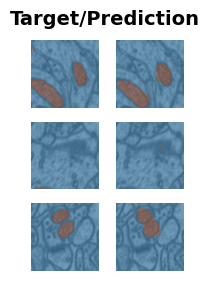

In [15]:
learn.show_results(max_n=3, figsize=(2,3))

In [16]:
lr = 1e-3
n_epochs = 50
opt = ranger
learn = unet_learner(dls, resnet34, metrics=Dice, opt_func=opt)
learn.fine_tune(n_epochs,lr)


epoch,train_loss,valid_loss,dice,time
0,0.119935,0.081830,0.707758,00:26
1,0.069333,0.047226,0.838495,00:26
2,0.052188,0.041334,0.854737,00:26
3,0.044530,0.035079,0.893321,00:26
4,0.038712,0.031438,0.900140,00:26
5,0.033941,0.025717,0.921803,00:27
6,0.035425,0.026851,0.917582,00:26
7,0.031982,0.022375,0.932285,00:27
8,0.031838,0.024664,0.927796,00:26
9,0.028469,0.020332,0.936747,00:26


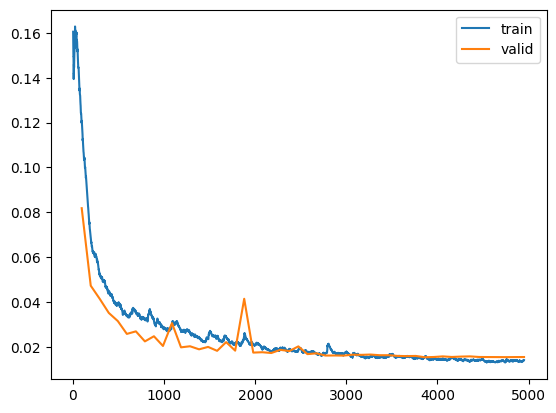

In [17]:
learn.recorder.plot_loss()


In [18]:
#1 This is the training loss at the end of the last epoch. 
# The training loss measures the difference between the model's predictions 
# and the true target values. A lower value indicates that the model is
# performing better on the training data.

#2 This is the value of the Dice coefficient (or Sørensen–Dice coefficient) metric 
# at the end of the last epoch. The Dice coefficient is a performance metric 
# commonly used for image segmentation tasks, measuring the similarity between two sets. 
# In this case, it compares the predicted segmentation mask and the ground truth mask.
# The Dice coefficient ranges from 0 to 1, where a higher value indicates better performance
# (a value of 1 means the predicted mask and ground truth mask are identical).

rec_vals = learn.recorder.values[-1]
print(len(rec_vals))
print(f'Training loss: {rec_vals[0]}')
print(f'Validation loss: {rec_vals[1]}')
print(f'Dice Coef: {rec_vals[2]}')


3
Training loss: 0.01399554405361414
Validation loss: 0.015392974950373173
Dice Coef: 0.952213532294518


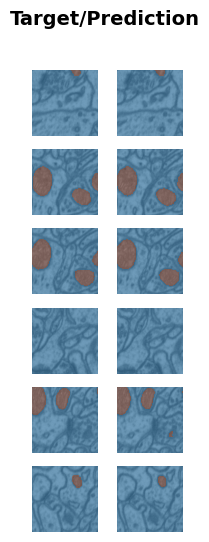

In [19]:
learn.show_results(max_n=6,figsize=(2,6))


In [20]:
# save the model 
os.makedirs("../segmentation_model_dir", exist_ok =True)
fname = f"dynamic_unet_seg_model-e{n_epochs}_b{batch_size}.pkl"
print(fname)

output_file = project_directory.joinpath(Path("segmentation_model_dir").joinpath(fname))

# saves the whole model, not just the weights
learn.export(output_file)


dynamic_unet_seg_model-e50_b16.pkl
